<a href="https://colab.research.google.com/github/MariaGabrielaAlvesZuppardo/SeriesTemporaisCin/blob/main/Lista_de_Exercicio_Random_Walk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Downloading the database and installing the necessary libraries

In [105]:
!pip install yfinance seaborn ipywidgets statsmodels

###  Importações necessárias

In [106]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error


from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import ipywidgets as widgets
import seaborn as sns # Import seaborn as sns

# Estilo de visualização corrigido
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('deep')




### Base de Dados Bitcoins

In [107]:
# 1. Download dos dados
ticket = "BTC-USD"
dados = yf.download(ticket, start="2018-01-01", end="2022-06-30")

# 2. Reamostragem mensal (último valor de cada mês)
dados_monthly = dados['Close'].resample('ME').last().dropna()
print(dados_monthly)


[*********************100%***********************]  1 of 1 completed

Ticker           BTC-USD
Date                    
2018-01-31  10221.099609
2018-02-28  10397.900391
2018-03-31   6973.529785
2018-04-30   9240.549805
2018-05-31   7494.169922
2018-06-30   6404.000000
2018-07-31   7780.439941
2018-08-31   7037.580078
2018-09-30   6625.560059
2018-10-31   6317.609863
2018-11-30   4017.268555
2018-12-31   3742.700439
2019-01-31   3457.792725
2019-02-28   3854.785400
2019-03-31   4105.404297
2019-04-30   5350.726562
2019-05-31   8574.501953
2019-06-30  10817.155273
2019-07-31  10085.627930
2019-08-31   9630.664062
2019-09-30   8293.868164
2019-10-31   9199.584961
2019-11-30   7569.629883
2019-12-31   7193.599121
2020-01-31   9350.529297
2020-02-29   8599.508789
2020-03-31   6438.644531
2020-04-30   8658.553711
2020-05-31   9461.058594
2020-06-30   9137.993164
2020-07-31  11323.466797
2020-08-31  11680.820312
2020-09-30  10784.491211
2020-10-31  13780.995117
2020-11-30  19625.835938
2020-12-31  29001.720703
2021-01-31  33114.359375
2021-02-28  45137.769531


### Random Walk com ruído

In [108]:
np.random.seed(42)
random_walk = np.cumsum(np.random.normal(0, 100, len(dados_monthly)))
plt.show()

In [109]:
dados_rw = pd.DataFrame({
    'Close': dados_monthly.values.squeeze(),  # Convertendo para 1D
    'Random Walk': random_walk
}, index=dados_monthly.index)
dados_rw['Close RW'] = dados_rw['Close'] + dados_rw['Random Walk']


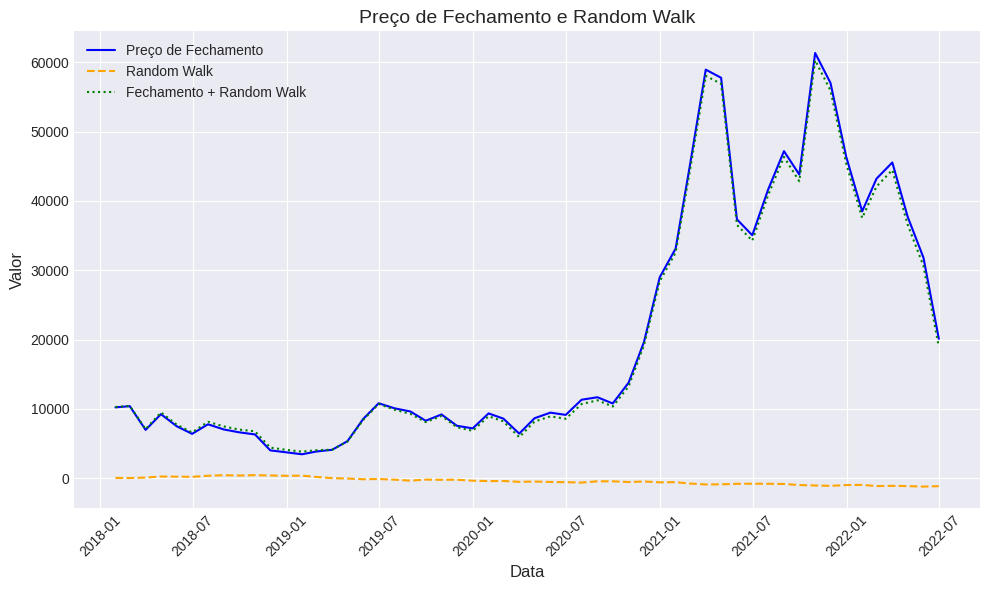

In [110]:
plt.figure(figsize=(10,6))
plt.plot(dados_rw.index, dados_rw['Close'], label='Preço de Fechamento', color='blue')
plt.plot(dados_rw.index, dados_rw['Random Walk'], label='Random Walk', color='orange', linestyle='--')
plt.plot(dados_rw.index, dados_rw['Close RW'], label='Fechamento + Random Walk', color='green', linestyle=':')

plt.title('Preço de Fechamento e Random Walk', fontsize=14)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Valor', fontsize=12)
plt.legend()

plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

### Autocorrelação e Estacionáriedade

Autocorrelações para os lags de 1 a 20:
Lag 1: 0.9459
Lag 2: 0.8693
Lag 3: 0.8161
Lag 4: 0.7844
Lag 5: 0.7376
Lag 6: 0.7015
Lag 7: 0.6765
Lag 8: 0.6368
Lag 9: 0.5908
Lag 10: 0.5243
Lag 11: 0.4833
Lag 12: 0.4219
Lag 13: 0.3359
Lag 14: 0.2485
Lag 15: 0.2057
Lag 16: 0.1979
Lag 17: 0.2127
Lag 18: 0.2368
Lag 19: 0.3154
Lag 20: 0.3832


<Figure size 1000x600 with 0 Axes>

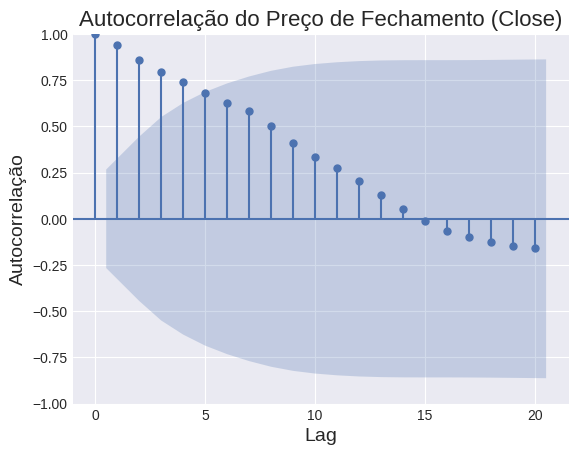

In [111]:
from statsmodels.graphics.tsaplots import plot_acf  # Importando a função plot_acf

# Calcular a autocorrelação para diferentes lags
max_lag = 20
autocorr_values = [dados_rw['Close'].autocorr(lag=i) for i in range(1, max_lag+1)]

# Exibir as autocorrelações para os lags de 1 a max_lag
print(f"Autocorrelações para os lags de 1 a {max_lag}:")
for i, autocorr in enumerate(autocorr_values, start=1):
    print(f"Lag {i}: {autocorr:.4f}")

# Plotando a autocorrelação para diferentes lags com melhorias no gráfico
plt.figure(figsize=(10, 6))
plot_acf(dados_rw['Close'], lags=max_lag, alpha=0.05)
plt.title('Autocorrelação do Preço de Fechamento (Close)', fontsize=16)
plt.xlabel('Lag', fontsize=14)
plt.ylabel('Autocorrelação', fontsize=14)
plt.grid(True)
plt.show()

In [112]:
# Cálculos das métricas
media_rw = np.mean(dados_rw['Random Walk'])
desvio_padrao_rw = np.std(dados_rw['Random Walk'])

# Calculando MSE e MAPE
mse_rw = mean_squared_error(dados_rw['Close'], dados_rw['Close RW'])
mape_rw = mean_absolute_percentage_error(dados_rw['Close'], dados_rw['Close RW'])

# Teste de Estacionaridade (ADF)
def test_stationarity(series):
    result = adfuller(series)
    return result[1]  # Retorna o p-value do teste

p_value_rw = test_stationarity(dados_rw['Random Walk'])
stationarity_result = "Estacionária" if p_value_rw < 0.05 else "Não Estacionária"

# Exibindo as métricas
print(f"Média do Random Walk: {media_rw:.2f}")
print(f"Desvio Padrão do Random Walk: {desvio_padrao_rw:.2f}")
print(f"MSE do Random Walk: {mse_rw:.2f}")
print(f"MAPE do Random Walk: {mape_rw:.2f}")
print(f"Teste de Estacionaridade: {stationarity_result} (p-value: {p_value_rw:.4f})")

Média do Random Walk: -388.82
Desvio Padrão do Random Walk: 496.22
MSE do Random Walk: 397414.02
MAPE do Random Walk: 0.04
Teste de Estacionaridade: Não Estacionária (p-value: 0.9510)


In [115]:
# Função para plotar as métricas com Plotly
def plot_metrics_plotly():
    metrics = {
        'Média': media_rw,
        'Desvio Padrão': desvio_padrao_rw,
        'MSE': mse_rw,
        'MAPE': mape_rw
    }

    # Criando o gráfico com Plotly
    fig = go.Figure()

    # Adicionando as métricas como linhas e marcadores
    fig.add_trace(go.Scatter(
        x=list(metrics.keys()),
        y=list(metrics.values()),
        mode='lines+markers',
        line=dict(color='blue', width=3),
        marker=dict(size=10, color='red'),
        name="Métrica"
    ))

    # Atualizando o layout do gráfico
    fig.update_layout(
        title='Métricas do Random Walk',
        xaxis_title='Métrica',
        yaxis_title='Valor',
        template='plotly_dark',
        showlegend=False
    )

    # Adicionando as anotações de valores no gráfico
    for i, (metric, value) in enumerate(metrics.items()):
        fig.add_annotation(
            x=metric,
            y=value + 5,  # Distância para as anotações não se sobreporem aos pontos
            text=f'{value:.2f}',
            showarrow=False,
            font=dict(size=12, color='white')
        )

    # Exibindo o gráfico interativo
    fig.show()

# Chama a função para gerar o gráfico
plot_metrics_plotly()



In [116]:

def generate_random_walk_2d_from_bitcoin(prices, std=100):
    returns = prices.pct_change().dropna()
    x_walk = np.cumsum(np.random.normal(loc=returns.mean(), scale=returns.std(), size=len(returns)))
    y_walk = np.cumsum(np.random.normal(loc=returns.mean(), scale=returns.std(), size=len(returns)))

    return x_walk, y_walk
ticket = "BTC-USD"
dados = yf.download(ticket, start="2007-08-18", end="2025-08-18")
dados_weekly = dados['Close'].resample('ME').last().dropna()
x_walk, y_walk = generate_random_walk_2d_from_bitcoin(dados_weekly)


# Usando o Plotly para gráfico interativo
def plot_random_walk_2d_plotly(x_walk, y_walk):
    # Criando o gráfico com Plotly
    fig = go.Figure()

    # Adicionando o passeio aleatório 2D como linha
    fig.add_trace(go.Scatter(
        x=x_walk,
        y=y_walk,
        mode='lines+markers',
        line=dict(color='blue', width=3),
        marker=dict(size=5, color='red'),
        name="Passeio Aleatório 2D"
    ))

    # Atualizando o layout do gráfico
    fig.update_layout(
        title='Passeio Aleatório 2D - Bitcoin',
        xaxis_title='Movimento Aleatório X',
        yaxis_title='Movimento Aleatório Y',
        template='seaborn',
        showlegend=True
    )

    # Exibindo o gráfico interativo
    fig.show()

# Plotando o passeio aleatório 2D de forma interativa
plot_random_walk_2d_plotly(x_walk, y_walk)

[*********************100%***********************]  1 of 1 completed
